In [3]:
!pip install scanpy gseapy scrublet


In [4]:
!pip install scanpy pandas

In [5]:
import scanpy as sc
import pandas as pd
import os

# --- 1. INTERACTIVE INPUT ---
print("--- Single-Cell Data Loader ---")
prefix = input("Enter the Sample Prefix (e.g., GSE245131_39): ").strip()
matrix_file = input("Enter Matrix filename (e.g., matrix.mtx.gz): ").strip()
features_file = input("Enter Features/Genes filename (e.g., features.tsv.gz): ").strip()
barcodes_file = input("Enter Barcodes filename (e.g., barcodes.tsv.gz): ").strip()

# --- 2. DOWNLOADER ---
# This builds the URL automatically based on your input
base_url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file={prefix}"

def download_file(fname):
    url = f"{base_url}{fname.replace('matrix', 'matrix').replace('features', 'features').replace('barcodes', 'barcodes')}"
    # Note: GEO encoding is tricky, so we use the prefix + name logic
    full_url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file={prefix}{fname}"
    print(f"📡 Downloading {prefix}{fname}...")
    !wget -O {fname} "{full_url}"

# Run the downloads
download_file(matrix_file)
download_file(features_file)
download_file(barcodes_file)

# --- 3. LOADING THE DATA ---
try:
    print("📦 Loading data into memory...")
    # Loading scRNA-seq (Matrix Market format)
    adata = sc.read_mtx(matrix_file).T

    # Load gene names (features) and cell names (barcodes)
    genes = pd.read_csv(features_file, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')

    # Assign names (Checking if features has 1 or 2 columns)
    if genes.shape[1] >= 2:
        adata.var_names = genes[1].values # Gene Symbols
    else:
        adata.var_names = genes[0].values # Gene IDs

    adata.obs_names = barcodes[0].values
    adata.var_names_make_unique()

    print(f"✅ SUCCESSFULLY LOADED: {prefix}")
    print(f"Stats: {adata.n_obs} cells | {adata.n_vars} genes")

except Exception as e:
    print(f"❌ Error: {e}")
    print("Tip: Check if the filenames you typed match the list exactly (case sensitive!)")

--- Single-Cell Data Loader ---
Enter the Sample Prefix (e.g., GSE245131_39): GSE245131_39
Enter Matrix filename (e.g., matrix.mtx.gz): matrix.mtx.gz
Enter Features/Genes filename (e.g., features.tsv.gz): features.tsv.gz
Enter Barcodes filename (e.g., barcodes.tsv.gz): barcodes.tsv.gz
📡 Downloading GSE245131_39matrix.mtx.gz...
--2026-01-23 11:48:56--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file=GSE245131_39matrix.mtx.gz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26881044 (26M) [application/octet-stream]
Saving to: ‘matrix.mtx.gz’

matrix.mtx.gz       100%[===================>]  25.64M  8.56MB/s    in 3.0s    

2026-01-23 11:49:00 (8.56 MB/s) - ‘matrix.mtx.gz’ saved [26881044/26881044]

📡 Downloading GSE245131_39features.tsv.gz...
--2026-01-23 11:49:00--  https:

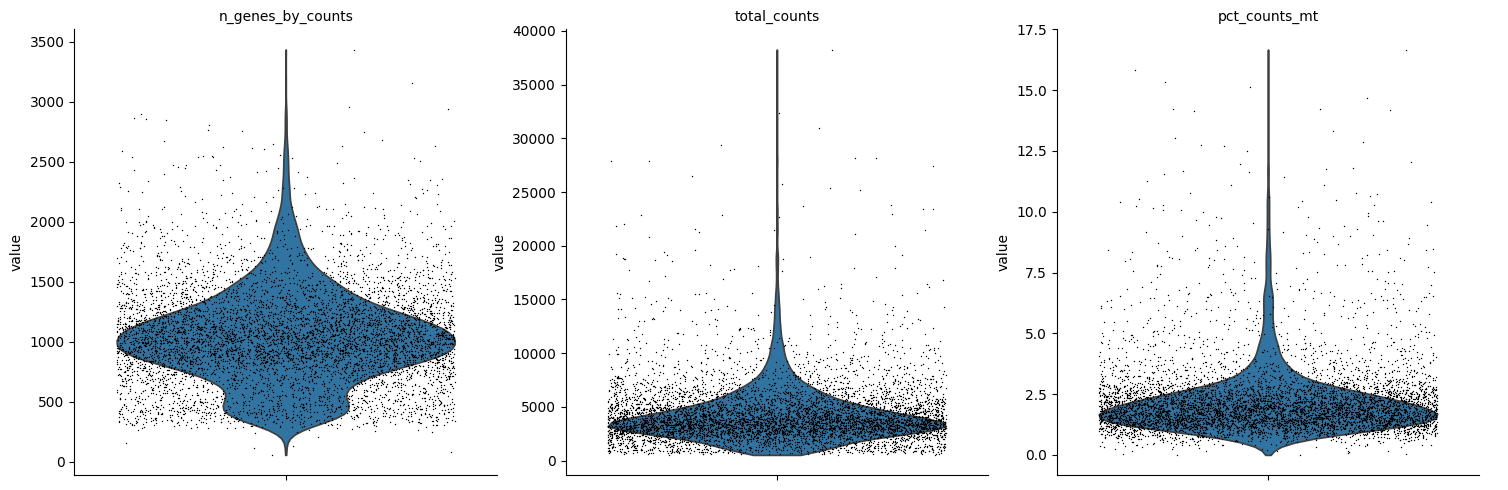

In [6]:
# 1. Label mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# 2. Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 3. Visualize QC (Look for the "humps" in the data)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [7]:
!pip install igraph leidenalg

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/tmp/ipython-input-2201209601.py:36: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5) # This creates the "Clusters"


✅ Data reset and re-processed successfully!


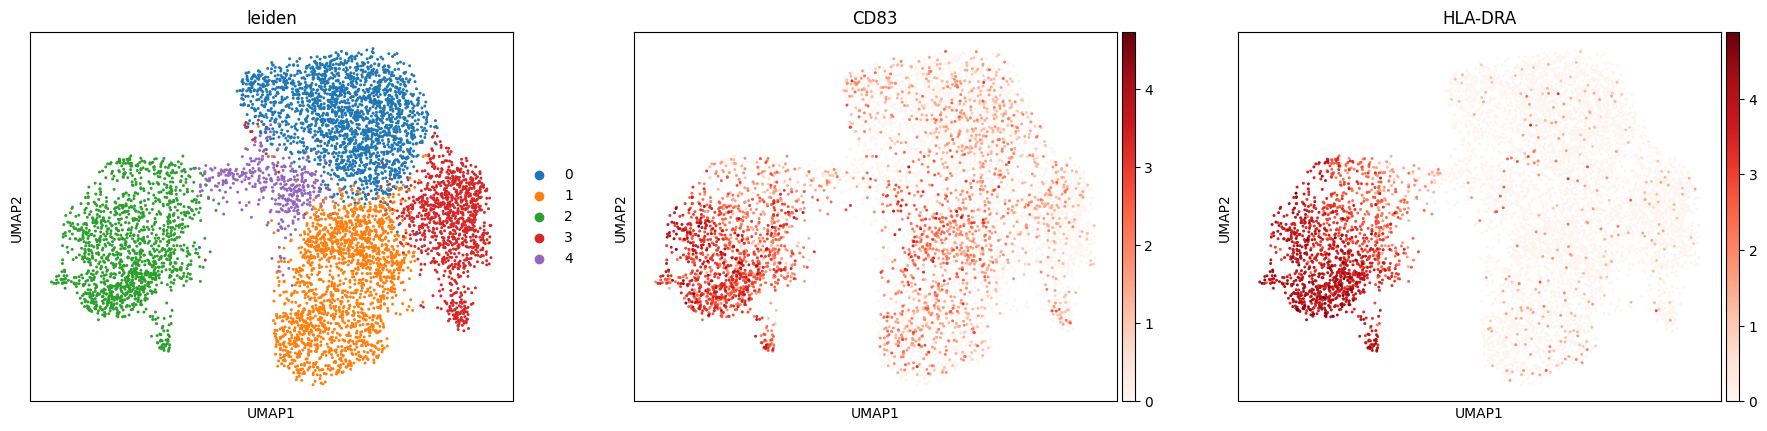

In [8]:
import scanpy as sc
import pandas as pd

# 1. Reload from the files already on your Colab (use the names you typed earlier)
# Assuming your variables 'matrix_file', 'features_file', 'barcodes_file' are still in memory
adata = sc.read_mtx(matrix_file).T
genes = pd.read_csv(features_file, header=None, sep='\t')
barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')

if genes.shape[1] >= 2:
    adata.var_names = genes[1].values
else:
    adata.var_names = genes[0].values
adata.obs_names = barcodes[0].values
adata.var_names_make_unique()

# --- THE STABLE PIPELINE ---
# 2. Basic Filtering (gentle)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 3. Normalization (Only run ONCE)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 4. Feature Selection (We store the full data in 'raw' so we don't lose it)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000) # Easier way to avoid empty arrays
adata = adata[:, adata.var.highly_variable]

# 5. Math & Mapping
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15) # Default is 15
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5) # This creates the "Clusters"

print("✅ Data reset and re-processed successfully!")
sc.pl.umap(adata, color=['leiden', 'CD83', 'HLA-DRA'], cmap='Reds')